## Test Image vs Pred Test Image

  - test image에 대한 inference 이후, 실제 이미지와 비교하는 EDA입니다.

In [1]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2

import numpy as np
import pandas as pd

# 전처리를 위한 라이브러리
#from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

#import albumentations as A
#from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()
from matplotlib.patches import Patch
import webcolors

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

# GPU 사용 가능 여부에 따라 device 정보 저장
device = "cuda" if torch.cuda.is_available() else "cpu"

pytorch version: 1.6.0
GPU 사용 가능 여부: True
Tesla V100-PCIE-32GB
1


In [2]:
class_colormap = pd.read_csv("class_dict.csv")
class_colormap
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

In [11]:
root_dir = "/opt/ml/segmentation/input/data" # 기존 이미지 데이터 경로 (batch 폴더들 위치)
best_output = "/opt/ml/segmentation/mmsegmentation/work_dirs/swin_plain/fold_4/submission_swin_plain_Fold_4.csv" # submission file 경로 (test file)
img_id = "batch_01_vt/0206.jpg" # 출력하고 싶은 image_id를 입력합니다.

In [12]:
# inference 이후, submission.csv 파일의 경로를 입력해줍니다. (test file)
eda_csv = pd.read_csv(best_output)
eda_csv

,image_id,PredictionString
0,batch_01_vt/0021.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1,batch_01_vt/0028.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,batch_01_vt/0031.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3,batch_01_vt/0032.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
4,batch_01_vt/0076.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
...,...,...
814,batch_03/0947.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
815,batch_03/0968.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
816,batch_03/0969.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
817,batch_03/0992.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [13]:
def make_elements(pred_cate):
    # variable for legend
    # pred_class를 나타내는 legend를 만들어 줍니다.
    category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values) if idx in pred_cate]

    legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                                edgecolor=webcolors.rgb_to_hex(rgb), 
                                label=category) for category, rgb in category_and_rgb]

    return legend_elements

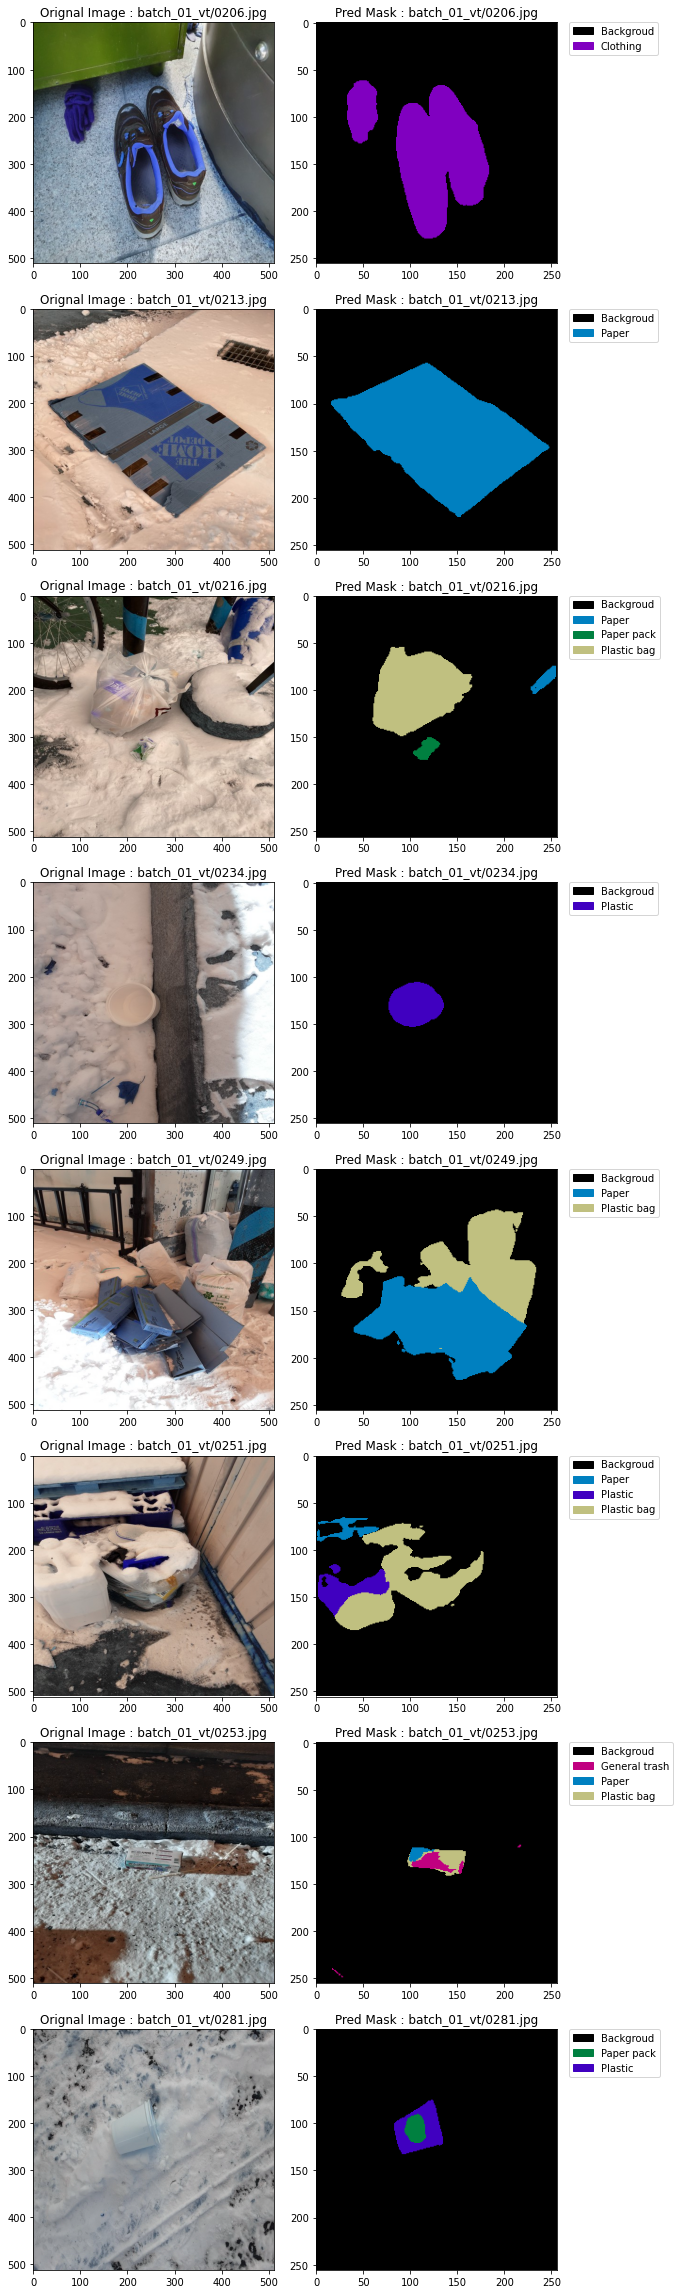

In [14]:
start_idx = eda_csv.index[eda_csv["image_id"]==img_id][0] # img_id의 idx를 뽑아줍니다.
num_examples = 8 # 뽑아낼 image 개수
num_cols = 2 # Original | Prediction

# plot
fig, ax = plt.subplots(nrows=num_examples, ncols=num_cols, figsize=(4*num_cols, 4*num_examples), constrained_layout=True)
fig.tight_layout()

for idx in range(start_idx, start_idx+num_examples):
    pred_str = eda_csv["PredictionString"][idx]
    pred_img_id = eda_csv["image_id"][idx]

    img_path = os.path.join(root_dir, pred_img_id)
    origin_img = cv2.imread(img_path)
    
    pred_cate = list(map(int, set(pred_str.split())))
    pred_str_reshape = np.array(list(map(int, pred_str.split()))).reshape(256,256)

    # plot row_num
    row_num = idx-start_idx

    # Original Image
    ax[row_num][0].imshow(origin_img)
    ax[row_num][0].set_title(f"Orignal Image : {pred_img_id}")
    
    # Pred Mask
    ax[row_num][1].imshow(label_to_color_image(pred_str_reshape))
    ax[row_num][1].set_title(f"Pred Mask : {pred_img_id}")

    # Pred Class
    ax[row_num][1].legend(handles=make_elements(pred_cate), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

plt.show()